Explore the Barents-2.5km dataset used in Kvanum et al.
* [Directory of Barents-2.5km Surface Variables]()
* [Script to Crawl Thredds](https://github.com/steingod/downloadfromthredds/blob/main/script/downloadfromthredds.py)

A high-level overview of the Barents-2.5km model is available [here](https://ocean.met.no/models#barents). A paper describing the Barents-2.5km model is available [here](https://gmd.copernicus.org/articles/16/5401/2023/gmd-16-5401-2023.pdf).

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import nctoolkit as nc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import iris

## 1. Load Barents-2.5 Forecast

In [2]:
ds = nc.open_thredds("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_surface/2025/01/31/T00Z/barents_sfc_20250131T00Zm00.nc")
ds

<nctoolkit.DataSet>:
Number of files: 1
File contents:
             variable ntimes  npoints  nlevels                                     long_name             unit data_type
0                Cs_r   None       42        1  S-coordinate stretching curves at RHO-points             None       F64
1                Cs_w   None       43        1    S-coordinate stretching curves at W-points             None       F64
2       forecast_hour   None        1        1       model hour since start of bulletin time             None       I32
3                 AKs   None   701311        1       Salinity vertical diffusion coefficient  meter2 second-1       F32
4               Uwind   None   701311        1                      surface u-wind component   meter second-1       F32
5               Vwind   None   701311        1                      surface v-wind component   meter second-1       F32
6               angle   None   701311        1                angle between XI-axis and EAST          rad

In [51]:
ice_concentration = ds.to_xarray(variables="ice_concentration")
ice_concentration

CDO warning: cdi  warning (cdf_set_var): inconsistent variable definition for lat!
CDO warning: cdi  warning (cdf_set_var): inconsistent variable definition for lon!


<xarray.Dataset> Size: 283MB
Dimensions:             (Y: 949, X: 739, time: 97)
Coordinates:
    lon                 (Y, X) float64 6MB ...
    lat                 (Y, X) float64 6MB ...
  * X                   (X) float32 3kB 2.786e+05 2.811e+05 ... 2.124e+06
  * Y                   (Y) float32 4kB -8.979e+05 -8.954e+05 ... 1.472e+06
  * time                (time) datetime64[ns] 776B 2025-01-31 ... 2025-02-04
Data variables:
    projection_lambert  int32 4B ...
    ice_concentration   (time, Y, X) float32 272MB ...
Attributes: (12/34)
    CDI:               Climate Data Interface version 2.2.4 (https://mpimet.m...
    Conventions:       CF-1.4, SGRID-0.3
    file:              /lustre/storeB/project/fou/hi/oper/barents_eps/rundir/...
    type:              ROMS/TOMS history file
    title:             Barents-2.5km - ROMS
    var_info:          /home/havis/sea/ROMS/metroms_apps/barents-2.5km/includ...
    ...                ...
    tiling:            008x010
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       BARENTS, ADD_FSOBC, ADD_M2OBC, ALBEDO, ANA_BSFLUX, ANA...
    NCO:               netCDF Operators version 4.8.1 (Homepage = http://nco....
    history:           Tue Feb 04 13:10:58 2025: cdo -L -selname,ice_concentr...
    CDO:               Climate Data Operators version 2.2.2 (https://mpimet.m...

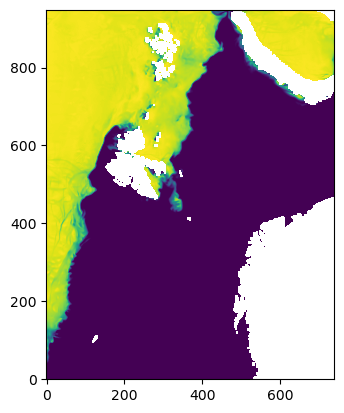

In [4]:
plt.imshow(ice_concentration.ice_concentration.isel(time=0), origin="lower")

## 2. Create Video from Barents-2.5 Forecast

In [5]:
# animate 24 hour loop of SIC
# edge animation
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fps = 10
def update(step):
    im.set_data(ice_concentration.ice_concentration.isel(time=step).to_numpy())
    title.set_text(f"Barents-2.5km Model Run 20250131T00Z\nValid {ice_concentration.ice_concentration.time[step].to_numpy()}")
im = ax.imshow(ice_concentration.ice_concentration.isel(time=0).to_numpy(), vmin=0, vmax=1, origin="lower", animated=True)
title = plt.suptitle(f"Barents-2.5km Model Run 20250131T00Z\nValid {ice_concentration.ice_concentration.time[0].to_numpy()}")
plt.tight_layout()
animation = FuncAnimation(fig, update, range(len(ice_concentration.ice_concentration.time)), interval=1000 / fps)
plt.close()
animation.save(f"icenet-experimental/barents/20250131T00Z.mp4", fps=fps)

## 3. Reproject Barents-2.5 onto AMSR

In [8]:
amsr = xr.open_dataset("/data/twins/wip/common/sic/amsr2/south/asi-AMSR2-s6250-20230102-v5.4.nc")
amsr

<xarray.Dataset> Size: 7MB
Dimensions:              (x: 1264, y: 1328)
Coordinates:
  * x                    (x) float64 10kB -3.947e+06 -3.941e+06 ... 3.947e+06
  * y                    (y) float64 11kB -3.947e+06 -3.941e+06 ... 4.347e+06
Data variables:
    polar_stereographic  |S1 1B ...
    z                    (y, x) float32 7MB ...
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.4.3 (r19528) [64-bit]
    history:      Tue Jan 03 05:27:52 2023: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.2.3, released 2017/11/20

In [98]:
amsr_cube = iris.load_cube("/data/twins/wip/common/sic/amsr2/north/asi-AMSR2-n6250-20250131-v5.4.nc")
amsr_cube

Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.


<iris 'Cube' of z / (unknown) (projection_y_coordinate: 1792; projection_x_coordinate: 1216)>

In [52]:
# TIL: you have to write dates as some other datatype
ice_concentration["time"] = ice_concentration.time.values.astype("int")
ice_concentration.to_netcdf("icenet-experimental/barents/barents.nc")

In [99]:
barents_cube = iris.load_cube("icenet-experimental/barents/barents.nc")
barents_cube

Missing CF-netCDF measure variable 'tarea', referenced by netCDF variable 'ice_concentration'
Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.


<iris 'Cube' of sea_ice_area_fraction / (1) (time: 97; projection_y_coordinate: 949; projection_x_coordinate: 739)>

In [100]:
amsr_cube.coord_system()

PolarStereographic(central_lat=90.0, central_lon=-45.0, false_easting=0.0, false_northing=0.0, true_scale_lat=70.0, ellipsoid=GeogCS(semi_major_axis=6378137.0, semi_minor_axis=6356752.314245179))

In [101]:
barents_cube.coord_system()

LambertConformal(central_lat=77.5, central_lon=-25.0, false_easting=0.0, false_northing=0.0, secant_latitudes=(77.5, 77.5), ellipsoid=GeogCS(6371000.0))

In [102]:
amsr_cube.data.data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]], dtype=float32)

Text(0.5, 1.0, 'Barents-2.5km Model Run 20250131T00Z')

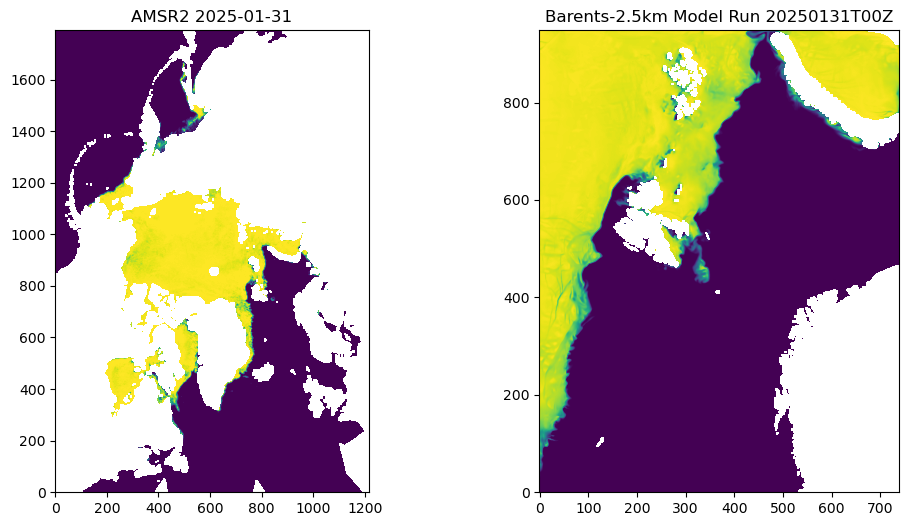

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(amsr_cube.data.data, origin="lower")
ax[0].set_title("AMSR2 2025-01-31")
ax[1].imshow(barents_cube.data[0], origin="lower")
ax[1].set_title("Barents-2.5km Model Run 20250131T00Z")

In [129]:
barents_cube_on_amsr = barents_cube.regrid(amsr_cube, iris.analysis.Linear(extrapolation_mode="nanmask"))

In [182]:
from shapely.geometry import Polygon
latitude = barents_cube.coord('latitude').points
longitude = barents_cube.coord('longitude').points
lat_min, lat_max = latitude.min(), latitude.max()
lon_min, lon_max = longitude.min(), longitude.max()

boundary_points = [
    (lon_min, lat_min),
    (lon_min, lat_max),
    (lon_max, lat_max),
    (lon_max, lat_min),
    (lon_min, lat_min)  # Closing the polygon
]

polygon = Polygon(boundary_points)
print(polygon)

POLYGON ((-17.956998825073242 62.134151458740234, -17.956998825073242 87.62052154541016, 79.56354522705078 87.62052154541016, 79.56354522705078 62.134151458740234, -17.956998825073242 62.134151458740234))


In [189]:
barents_cube_on_amsr.data[0]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

Text(0.5, 1.0, 'Barents-2.5km Model Run 20250131T00Z on AMSR2 Grid')

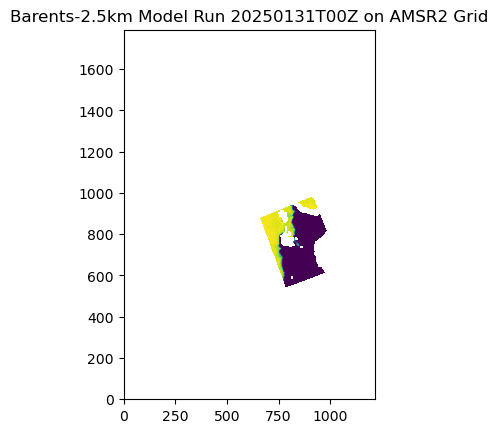

In [191]:
import numpy as np
plt.imshow(barents_cube_on_amsr.data[0], origin="lower")
# plt.plot(*polygon.exterior.xy)
plt.title("Barents-2.5km Model Run 20250131T00Z on AMSR2 Grid")

In [132]:
amsr_cube_on_barents = amsr_cube.regrid(barents_cube, iris.analysis.Linear(extrapolation_mode="nanmask"))

Text(0.5, 1.0, 'AMSR2 2025-01-31 Obs on Barents-2.5km Model Grid')

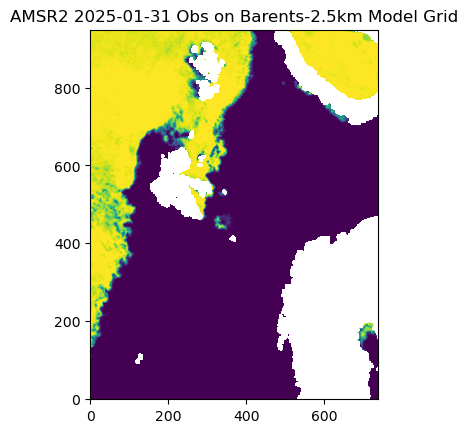

In [134]:
plt.imshow(amsr_cube_on_barents.data, origin="lower")
plt.title("AMSR2 2025-01-31 Obs on Barents-2.5km Model Grid")

Text(0.5, 1.0, 'AMSR2 - Barents-2.5km Model Run 2025-01-31T00Z')

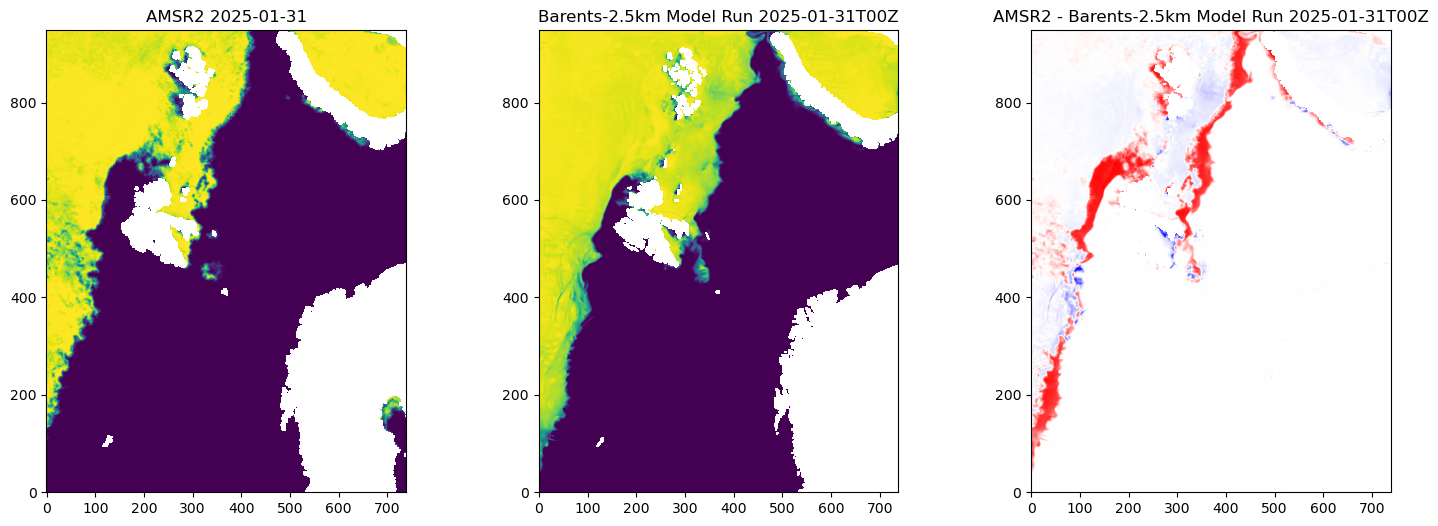

In [141]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(amsr_cube_on_barents.data.data, origin="lower")
ax[0].set_title("AMSR2 2025-01-31")
ax[1].imshow(barents_cube.data[0], origin="lower")
ax[1].set_title("Barents-2.5km Model Run 2025-01-31T00Z")
ax[2].imshow(amsr_cube_on_barents.data.data/100 - barents_cube.data[0], origin="lower", vmin=-1, vmax=1, cmap="bwr_r")
ax[2].set_title("AMSR2 - Barents-2.5km Model Run 2025-01-31T00Z")

## 4. Compare with neXtSIM

In [147]:
nextsim = iris.load("/data/hpcdata/users/anddon76/icenet/icenet-experimental/nextsim/ARCTIC_ANALYSISFORECAST_PHY_ICE_002_011/cmems_mod_arc_phy_anfc_nextsim_hm_202311/2025/01/20250131_hr-nersc-MODEL-nextsimf-ARC-b20250201-fv00.0.nc")
nextsim

Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum

[<iris 'Cube' of Sea Ice Volume Fraction of Ridged Ice / (1) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>,
<iris 'Cube' of age_of_sea_ice / (years) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>,
<iris 'Cube' of sea_ice_albedo / (1) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>,
<iris 'Cube' of sea_ice_area_fraction / (1) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>,
<iris 'Cube' of sea_ice_classification / (1) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>,
<iris 'Cube' of sea_ice_classification / (1) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>,
<iris 'Cube' of sea_ice_thickness / (m) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>,
<iris 'Cube' of sea_ice_x_velocity / (m s-1) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>,
<iris 'Cube' of sea_ice_y_velocity / (m s-1) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>,
<iris 'Cube' of surface_snow_thickness / (m) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>]

In [150]:
nextsim_cube = nextsim[3]  # sea ice concentration cube
nextsim_cube

<iris 'Cube' of sea_ice_area_fraction / (1) (time: 24; projection_y_coordinate: 2367; projection_x_coordinate: 2467)>

In [151]:
nextsim_cube_on_barents = nextsim_cube.regrid(barents_cube, iris.analysis.Linear(extrapolation_mode="nanmask"))

Text(0.5, 1.0, 'neXtSIM 2025-01-31 Step 0 on Barents-2.5km Model Grid')

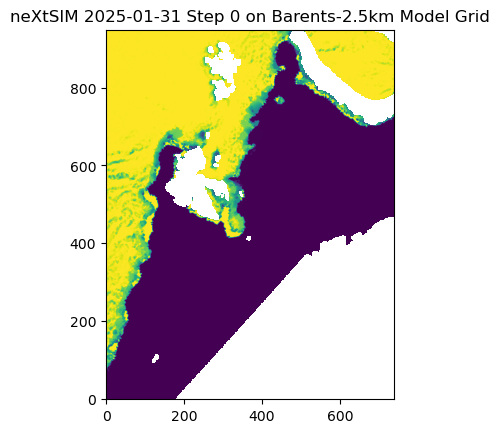

In [153]:
plt.imshow(nextsim_cube_on_barents.data[0], origin="lower")
plt.title("neXtSIM 2025-01-31 Step 0 on Barents-2.5km Model Grid")

Text(0.5, 1.0, 'neXtSIM - AMSR2')

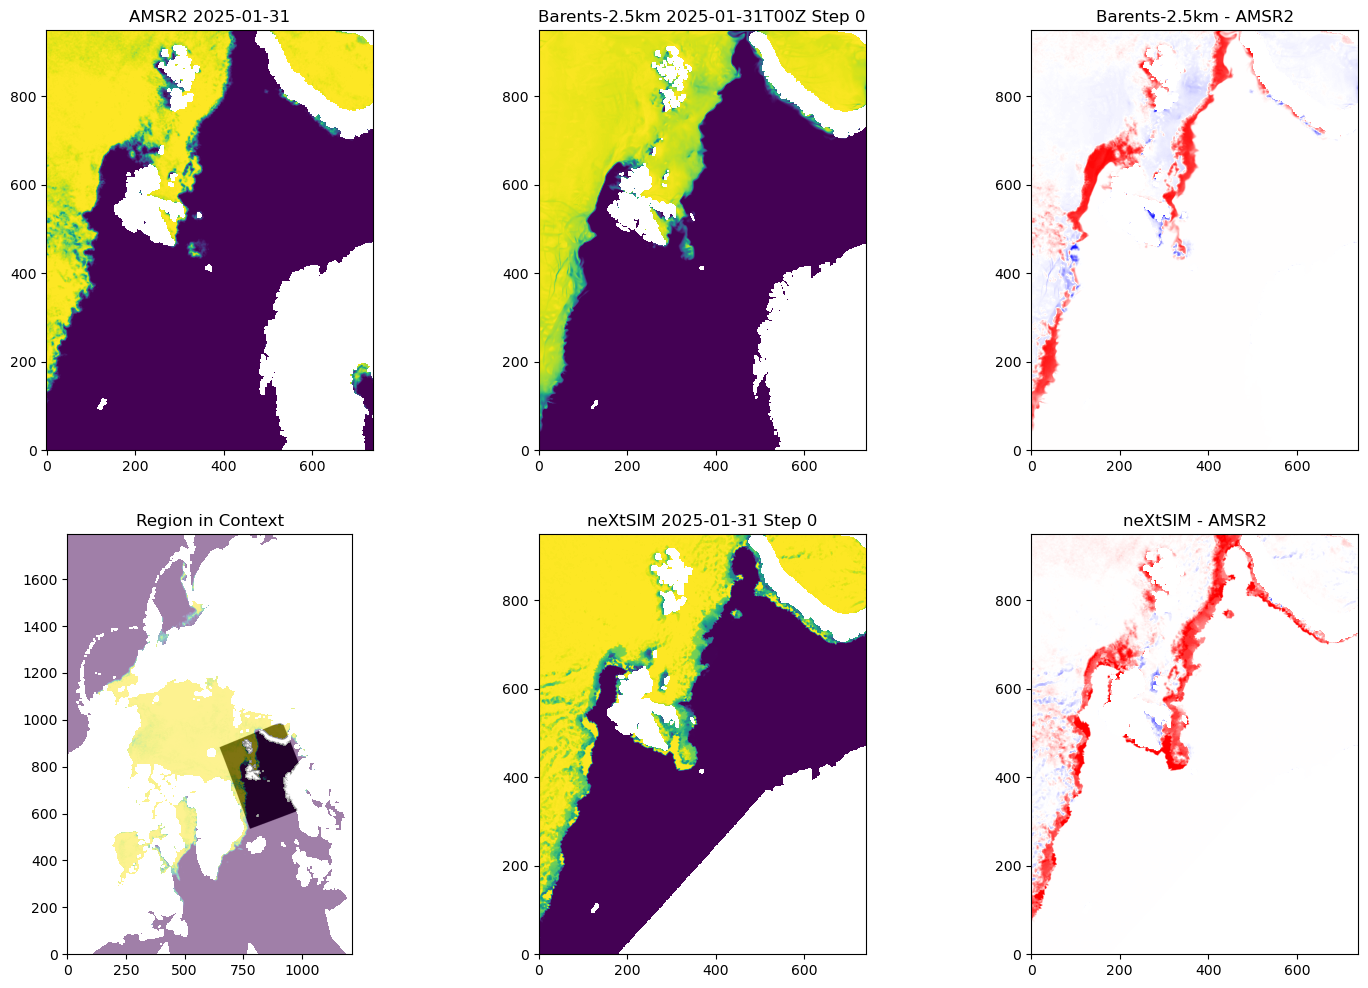

In [195]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
ax = ax.ravel()
ax[0].imshow(amsr_cube_on_barents.data.data, origin="lower")
ax[0].set_title("AMSR2 2025-01-31")
ax[1].imshow(barents_cube.data[0], origin="lower")
ax[1].set_title("Barents-2.5km 2025-01-31T00Z Step 0")
ax[2].imshow(barents_cube.data[0] - amsr_cube_on_barents.data.data/100, origin="lower", vmin=-1, vmax=1, cmap="bwr")
ax[2].set_title("Barents-2.5km - AMSR2")
ax[3].imshow(amsr_cube.data.data, origin="lower")
ax[3].imshow(barents_cube_on_amsr.data[0].mask, origin="lower", alpha=0.5, cmap="grey")
ax[3].set_title("Region in Context")
ax[4].imshow(nextsim_cube_on_barents.data[0], origin="lower")
ax[4].set_title("neXtSIM 2025-01-31 Step 0")
ax[5].imshow(nextsim_cube_on_barents.data[0] - amsr_cube_on_barents.data.data/100, origin="lower", vmin=-1, vmax=1, cmap="bwr")
ax[5].set_title("neXtSIM - AMSR2")